<div class="alert alert-warning">
This is an exercise to be handed in on Peergrade
</div>

In [13]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

*You should first read the introduction from the Notebook about Autoencoders (notebook 7.1).*

As background material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you can read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014: http://arxiv.org/pdf/1401.4082v3.pdf.

# Variational Autoencoders

Probabilistic Machine Learning is fundamental in modern machine learning. While deep learning methods have been criticized for their lack of explainability, building machine learning models using probabilistic principles provides statistical guarantees. This is a key component for deploying machine learning to critical infrastructures (healthcare, manufacturing, finance, etc..). The Variational Autoencoder embodies probabilistic principles for principled unsupervised learning.

## 1. Probabilistic Design:  Designing a Generative Process

<img src="https://github.com/alaym3/02456-deep-learning-with-PyTorch/blob/master/7_Unsupervised/static/vae.png?raw=1" />

In the notebook 7.1, the goal was to learn a set of features $\mathbf{z} \in \mathcal{R}^M$ explaining the *observation* variable $\mathbf{x} \in \mathcal{R}^{P}$. Learning was performed by autoencoding $\mathbf{x}$ through an *information bottleneck*. In this setting however, the quality of the representation is greatly impacted by the choice of the dimension $M$ of the bottleneck.

The unobserved variable -- or *latent variable* -- can be modelled using a probabilistic framework, this allows us to build the model in a principled way, and overcomes many of the limitations of the basic autoencoder (e.g. choice of the dimension of the bottleneck). $\mathbf{z}$ is chosen to represent the generative factors of $\mathbf{x}$, we define a generative process 

$$\mathbf{z} \sim p_{\theta}(\mathbf{z}), \  \mathbf{x} \sim p_{\theta}(\mathbf{x} | \mathbf{z})$$ 

where the **prior** $p_{\theta}(\mathbf{z})$ is a chosen distribution (e.g. $\mathcal{N}(0 , I)$) and the **observation model** $p_\theta(\mathbf{x} | \mathbf{z})$ is a distribution depending on the variable $\mathbf{z}$. Since we are interested in learning a model that explains well the data, we aim at maximizing the probability assigned to $\mathbf{x}$. Therefore the optimal parameter $\theta^\star$ is given by

$$\theta^\star := \mathop{\mathrm{argmax}}_\theta p_\theta (\mathbf{x}) = \int_\mathbf{z} p_\theta(\mathbf{x}, \mathbf{z}) d\mathbf{z} = \int_\mathbf{z} p_\theta(\mathbf{x} | \mathbf{z}) p_\theta(\mathbf{z}) d \mathbf{z} \ .$$

## 2. Amortized Variational Inference: Estimatin the Likelihood 

### Intractability of the Likelihood

In practice, $p_{\theta}(\mathbf{x})$ is **intractable**: marginalizing over $\mathbf{z}$ is prohibitively expensive. A potential solution consists in using the *posterior distribution* which we can express using Bayes Rule:

$$p_\theta(\mathbf{z} | \mathbf{x}) =  \frac{p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})}{p_{\boldsymbol{\theta}}(\mathbf{x})} \ . $$

However $p_\theta(\mathbf{x} | \mathbf{z})$ is also intractable as it requires evaluating $p_\theta (\mathbf{x} )$.

### Approximate Posterior

**Variational Inference** (VI) overcomes the intractability of the *true posterior* $p_\theta(\mathbf{z} | \mathbf{x})$ by introducing an **approximate posterior**

$$q_\phi(\mathbf{z} | \mathbf{x}) \approx p_\theta(\mathbf{z} | \mathbf{x}) \ . $$ 

$q_\phi(\cdot| \mathbf{x})$ is chosen among a *variational family* $\mathcal{Q}$. A common choice for $\mathcal{Q}$ is the Gaussian family, although it is possible to use other families (Categorical, Poisson, etc..). In the case of the Gaussian family, a common choice is the isotropic Gaussian (diagonal covariance)

$$q_\phi(\mathbf{z} | \mathbf{x}) := \mathcal{N}( \mathbf{z}\ |\ \mu_\phi(\mathbf{x}) , \sigma_\phi(\mathbf{x}) I )$$

parameterized by neural networks $\mu_\phi(\mathbf{x}) $ and $ \sigma_\phi(\mathbf{x})$. Because the inference model $\{ \mu_\phi, \sigma_\phi \}$ is shared among all datapoints $\{\mathbf{x}_i, \mathbf{y}_i\}_{i=1, \dots, N}$, we say that we use **amortized** Variational Inference. Non-amortized Variational Inference would consider one model $\{ \mu_\phi, \sigma_\phi \}$ for each datapoint $\mathbf{x}$.

The introduction of the approximate posterior allows to express the likelihood $p_\theta (\mathbf{x})$ as an expectation over $q_\phi(\mathbf{z} | \mathbf{x})$:

$$
\begin{align}
p_\theta (\mathbf{x})  = \int_\mathbf{z} p_\theta(\mathbf{x} ,\mathbf{z}) d \mathbf{z}
= \int_\mathbf{z} \frac{q_\phi(\mathbf{z} | \mathbf{x})}{q_\phi(\mathbf{z} | \mathbf{x})} p_\theta(\mathbf{x}, \mathbf{z}) d \mathbf{z}
= \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[
\frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} | \mathbf{x})}
\right]
\end{align}
$$


### Evidence Lower Bound (ELBO)

Computing a Monte-Carlo estimate $\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ \cdot \right]$ of the ratio $\frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} | \mathbf{x})}$
is computationally challenging due to its high variance and the numerically instability cause by the term $\frac{1}{q_\phi(\mathbf{z} | \mathbf{x})}$. Instead, we leverage well-behaved log-space computation thanks to [Jensen's Inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality), which gives the Evidence Lower Bound (ELBO) $\mathcal{L} (\mathbf{x})$:

$$
\begin{align}
\log p_\theta (\mathbf{x}) & = \log \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ 
\frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} | \mathbf{x})} 
\right]  \geq  \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ 
\log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} | \mathbf{x})} 
\right] =: \mathcal{L} (\mathbf{x})
\end{align}
$$

Is it possible to express the ELBO using [a KL divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), which measure how two distributions differ from each other: 


$$
\mathcal{L}(\mathbf{x}) := \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ 
\log p_\theta(\mathbf{x} | \mathbf{z}) - \log q_\phi(\mathbf{z} | \mathbf{x}) + \log p_\theta(\mathbf{z}) 
\right] =
\overbrace{
\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ \log p_\theta(\mathbf{x} | \mathbf{z})\right]
}^{\text{(a) Reconstruction Error}}
- 
\overbrace{
\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)
}^{\text{(b) Regularization}}
$$

Optimizing the ELBO results in a tradeoff between the terms (a) and (b). The term (a) mesaures the reconstruction quality while the term (b) enforces the posterior $q_\phi(\mathbf{z} | \mathbf{x})$ to match the prior $p(\mathbf{z})$. A stronger regularization (penalizing more the KL term b.), the more difficult it is to produce good reconstructions.


## 3. Learning the Optimal Parameters: the Reparameterization Trick

The ELBO is a lower bound to the log-likelihood,meaning that maximizing the ELBO results in maximizing the likelihood.
Assuming that both the inference network $q_\phi(\mathbf{z} | \mathbf{x})$ and
the generative model $p_\theta(\mathbf{x} | \mathbf{z})$ are implemented using network, we can apply backpropagation
through all layers but not through the sampling operation $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$. In the next paragraph we will see how to optimize the parameters $\theta$ and $\phi$ w.r.t $\mathcal{L}$.

### Optimizing $\theta$: Backropagation

The ELBO is a lower bound to the marginal log-likelihood: $ \mathcal{L} \leq \log p_\theta (\mathbf{x})$.
Therefore we use stochastic gradient descent to minimize the negative ELBO. The gradient of the parameters $\theta$ can be evaluated analytically
using backpropagation (see the computational graph in the figure section *reparameterization trick*).

###  Optimizing $\phi$: Monte Carlo Gradient Estimation and the Reparameterization Trick

**Estimating the gradient w.r.t $\phi$ is challenging** due to the sampling operation $\mathbf{z} \sim q_{\phi}(\mathbf{z} | \mathbf{x})$
that requires integrating over $q_\phi(\mathbf{z}|\mathbf{x})$. Here is an extensive review of the existing methods for
[Monte Carlo Gradient Estimation in Machine Learning](https://arxiv.org/pdf/1906.10652.pdf).

#### Naïve approach: Reinforce

The usual Monte Carlo Gradient estimator for this type of problem is the Reinforce -- or the score-function -- gradient estimator.
In a simplified setting of a loss function (score) of the general form $f_{\theta}(\mathbf{z},  \mathbf{x})$, the following identify holds: $$\nabla_{\boldsymbol{\phi}} \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} | \mathbf{x})}[f_\theta(\mathbf{z}, \mathbf{x})]=\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} |  \mathbf{x})}\left[f_\theta(\mathbf{z},  \mathbf{x}) \nabla_{\phi} \log q_{\boldsymbol{\phi}}(\mathbf{z} |  \mathbf{x})\right] \text{  (Reinforce)}$$ . This gradient estimator suffers however from large variance, as a consequence learning will be inefficient.

#### The Reparameterization Trick / Pathwise Derivatives

<img src="https://github.com/alaym3/02456-deep-learning-with-PyTorch/blob/master/7_Unsupervised/static/reparameterization.png?raw=1" width="70%" />

The key component of the [the original Variational Autoencoder](https://arxiv.org/pdf/1312.6114.pdf) consists in using the Law of the Unconscious Statistician (LOTUS)
to derive a **low-variance estimate of the gradient of $\phi$**: this is the **Reparameterization Trick** (also known as pathwise derivatives). The trick consists in
1. introducing a noise variable $\epsilon$ with a fixed base distribution $p(\epsilon)$
2. introducing a deterministic and differentiable transformation $g_\phi (\epsilon, \mathbf{x})$

Such that $$\mathbf{z} \sim q_\phi(\mathbf{z}| \mathbf{x}) \text{ is equivalent to } \mathbf{z} = g_\phi(\epsilon, \mathbf{x}), \epsilon \sim p(\epsilon) \ .$$

In this setting, a low-variance estimate of the gradient of the ELBO w.r.t $\phi$ is given by:

$$\nabla_\phi \mathcal{L}(\mathbf{x}) := \nabla_\phi \mathbb{E}_{q_{\phi}\left(\mathbf{z} \mid \mathbf{x}\right)}[f_{\theta, \phi}(\mathbf{z}, \mathbf{x})]=\mathbb{E}_{p(\boldsymbol{\epsilon})}\left[ \nabla_\phi f_{\theta, \phi}\left(\tilde{\mathbf{z}}, \mathbf{x}\right)\right] \text{  (Reparameterization)}$$

with $\tilde{\mathbf{z}} := g_{\boldsymbol{\phi}}\left(\boldsymbol{\epsilon},\mathbf{x} \right), \epsilon \sim p(\epsilon) \text{ and } f_{\theta, \phi}(\mathbf{z}, \mathbf{x}) := \log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z}|\mathbf{x})}$ .


#### Choice of Reparameterization

A common choice of parameterization is to choose $p(\epsilon) = \mathcal{N} (0, I)$ and parameterize a mean vector and a diagonal covariance matrix using neural networks $\{\mu_\phi, \sigma_\phi\}$:

$$\mathbf{z} = \mu_\phi(\mathbf{x}) + \sigma_\phi(\mathbf{x})  \odot \epsilon \ \text{   with   }  \epsilon \sim \mathcal{N} (0, I) \ . $$

### Why a VAE learns a good approximate posterior $q_\phi(\mathbf{z} | \mathbf{x}) \approx p_\theta(\mathbf{z} | \mathbf{x})$

We have seen how to estimate the parameter $\phi$ thanks to the reparameterization. Maximizing the ELBO will
maximize its upper bound $\log p_\theta(\mathbf{x})$. Yet, maximizing $\log p_\theta(\mathbf{x})$ does not guarantee a good approximation
$q_\phi(\mathbf{z} | \mathbf{x}) \approx p_\theta(\mathbf{z} | \mathbf{x})$, and a poor approximation leads to a low-accuracy estimate of $\log p_\theta(\mathbf{x})$.

At the end of the note book, we show that the following identity holds:

$$\log p_\theta(\mathbf{x}) = \mathcal{D}_{\operatorname{KL}}(q_\phi(\mathbf{z} | \mathbf{x}) | p_\theta(\mathbf{z}| \mathbf{x})) + \mathcal{L}(\mathbf{x}) \geq \mathcal{L}(\mathbf{x})$$

Hence maximizing the ELBO also guarantees to push the approximate posterior $q_\phi(\mathbf{z}| \mathbf{x})$ to be similar to the true posterior  $p_\theta(\mathbf{z}| \mathbf{x})$ because $\mathcal{D}_{\operatorname{KL}}(q_\phi(\mathbf{z} | \mathbf{x}) | p_\theta(\mathbf{z}| \mathbf{x}))$ is minimized as $\mathcal{L}$ is maximized.

## 4. Interpreting VAEs as Autoencoders

Similarly to the Autoencoder introduced in the previous notebook, the Variational Autoencoder admits an *encoder* model $g_\phi(\mathbf{x}, \epsilon)$ parameterizing the posterior $q_\phi(\mathbf{z} | \mathbf{x})$ and a *decoder* $h_\theta(\mathbf{z})$ parameterizing the observation model $p_\theta(\mathbf{x} | \mathbf{z})$. Hence, a VAE is much similar to a classic autoencoder (as introduced in the notebook 7.1): instead of computing $\mathbf{z} = h_\phi(\mathbf{x})$ (deterministic: autoencoder), a VAE exploits a stochastic model $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ (see the top figure). 

When using the reparameterization-trick, this is equivalent to adding noise to the stochastic representation $\mathbf{z} = \mu_\phi(\mathbf{x}) + \sigma_\phi(\mathbf{x})  \odot \epsilon$ with  $\epsilon \sim \mathcal{N} (0, I)$.

The ELBO introduces a tradeoff between reconstruction quality and the regularizer $\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$. It is possible to target different regularization strenghts using the following modified ELBO loss ([$\beta-VAE$](https://openreview.net/references/pdf?id=Sy2fzU9gl)):

$$
\mathcal{L}^{\beta}(\mathbf{x}) := 
\overbrace{
\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ \log p_\theta(\mathbf{x} | \mathbf{z})\right]
}^{\text{(a) Reconstruction Error}}
- 
\beta
\cdot
\overbrace{
\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)
}^{\text{(b) Regularization}}
$$


## 5. Modelling Choices: How to design a VAE


### Prior $p_{\theta}(\mathbf{z})$

The prior distribution structures the latent space. Althougt it is common to choose a simple *variaitonal family* (Diagonal Gaussian or Categorical), more complex prior distributions can be used including complex factorizations (e.g. autoregressive: $p(\mathbf{z}) = p_\theta(\mathbf{z_1}) \prod_{l=1}^{L-1} p_{\theta}(\mathbf{z}_{l+1} | \mathbf{z}_l) $ ). By default, the prior is commonly chosen to be a simple Gaussian distribution: $$p(\mathbf{z}) := \mathcal{N}(0, I)$$

### Posterior $q_\phi(\mathbf{z}|\mathbf{x})$

The posterior is chosen to be of the same variational family as the prior. When using the reparameterization trick, the posterior must admit a reparameterization. A common choice fitting the Gaussian prior is a Diagonal Gaussian distribution: $$q_\phi(\mathbf{z} | \mathbf{x}) := \mathcal{N}( \mathbf{z}\ |\ \mu_\phi(\mathbf{x}) , \sigma_\phi(\mathbf{x}) I )$$


### Observation Model $p_\theta(\mathbf{x} | \mathbf{z})$

The choice of the observation model depends on the nature of the features, so for binary pixel values an appropiate choice of reconstruction distribution is the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), $$p_\theta(\mathbf{x}|\mathbf{z}) = \prod_i \mathcal{B}(x_i | g_\theta(\mathbf{z})) = \prod_i g_\theta(\mathbf{z})_i^{x_i} \cdot (1-g_\theta(\mathbf{z})_i)^{1-x_i}$$ where $x_1, \dots, x_D \in \{0,1\}^{D}$ are the pixel values of the image $\mathbf{x}$. $g_\theta$ is the *decoder* of the VAE. $g_\theta(z)_i$ is the probability of generating a 0 (black) or 1 (white) for the $i$-th pixel value. This is equivalent to modelling 784 imbalanced coin-tossing processes. This is only possible because we assume the pixel intensities to be i.i.d (Independent and Identically Distributed), which means $p(\mathbf{x}) = \prod_i p(x_i)$ , so no direct correlations between them needs to modelled, even though we still achieve an indirect conditional correlation through the latent variables, $\mathbf{z}$.


## 6. Evaluating a Variational Autoencoder

### Assessing the Quality of the Samples

The Variational Autoencoder defines a generative process $\mathbf{z} \sim p_{\theta}(\mathbf{z}), \  \mathbf{x} \sim p_{\theta}(\mathbf{x} | \mathbf{z})$. A *good* VAE should explain well the data $\mathbf{x}$ and samples $\mathbf{x} \sim p_{\theta}(\mathbf{x} |\mathbf{z}), \mathbf{z} \sim p_{\theta}(\mathbf{z})$ should be representive of the dataset.

### Estimating the Likelihood

A VAE defines a probabilistic model $p_\theta(\mathbf{x} | \mathbf{z}) p(\mathbf{z})$ and we are interested in maximizing the ability of the model to explain the dataset $\mathcal{D} = \{\mathbf{x}_i\}_{i=1, \dots, N}$, hence we aim at obtaining the maximum probability $\log p_\theta(\mathcal{D}) = \sum_{i=1}^N \log p_\theta(\mathbf{x}_i) =  \sum_{i=1}^N \log \int_\mathbf{z} p_\theta(\mathbf{x}_i, \mathbf{z}) d\mathbf{z} $. However, as discussed previously, the log-likelihood is intractable (marginalization over $\mathbf{z}$), hence we rely on the Evidence Lower Bound (ELBO) as a proxy, or a tighter bound such as the importance weighted bound (see at the end of the notebook). 

**NB** It is common practice to report the average marginal log likelihood $\log p_\theta(\mathcal{D}) / N$ and not $\log p_\theta(\mathcal{D})$ directly:

$$\frac{1}{N} \log p_\theta(\mathcal{D}) = \frac{1}{N} \sum_i \log p_\theta(\mathbf{x}_i) \geq \frac{1}{N} \sum_i \operatorname{ELBO}(\mathbf{x}_i) \ . $$

### Evaluation on Downstream Tasks

As explained in the previous notebook, there is an interest in learning *compressed* representations $\mathbf{z}$ of $\mathbf{x}$ with the intent of solving downstream tasks such as classification. In this scenario, it is important to evaluate the VAE on the final task. For instance, learning a classifier using $\mathbf{z}$ as features: $p(y | \mathbf{z})$.


# Practice: Building and Training VAEs

## Probabilistic Building Blocks

First, we will implement modules representing probability distributions, which are essential in probabilistic machine learning. Here, we loosely follow the implementation from the `torch.distributions` package which provides modules for most of the commonly used distributions. 

### 1. Gaussian Distribution

The Gaussian distribution is parameterized by two parameters:
* the location parameter $\mu$
* the scale parameter $\sigma \geq 0$.


**Exercise 1**: Implement a Gaussian distribution from the parameters $\mu$ and $\log \sigma$ using the following code. The method `rsample()` should be compatible with the reparameterization trick.

In [14]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions import Normal



class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return Normal(self.mu, self.sigma).rsample()  # <- your code
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return Normal(self.mu, self.sigma).log_prob(z) # <- your code

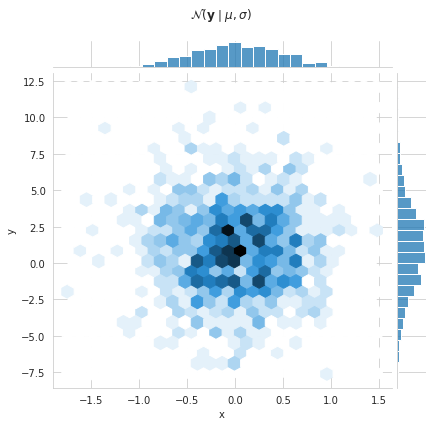

In [15]:
# test your implementation

def test_normal_distribution():
    """a few safety checks for your implementation"""
    N = 1000000
    ones = torch.ones(torch.Size((N,)))
    mu = 1.224 * ones
    sigma = 0.689 * ones
    dist = ReparameterizedDiagonalGaussian(mu, sigma.log())
    z = dist.sample()
    
    # Expected value E[N(0, 1)] = 0
    expected_z = z.mean()
    diff = (expected_z - mu.mean())**2
    assert diff < 1e-3, f"diff = {diff}, expected_z = {expected_z}"
    
    # Variance E[z**2 - E[z]**2]
    var_z = (z**2 - expected_z**2).mean()
    diff = (var_z - sigma.pow(2).mean())**2
    assert diff < 1e-3, f"diff = {diff}, var_z = {var_z}"
    
    # log p(z)
    from torch.distributions import Normal
    base = Normal(loc=mu, scale=sigma)
    diff = ((base.log_prob(z) - dist.log_prob(z))**2).mean()
    assert diff < 1e-3, f"diff = {diff}"

test_normal_distribution()   

n_samples = 10000
mu = torch.tensor([[0, 1]])
sigma = torch.tensor([[0.5 , 3]])
ones = torch.ones((1000,2))
p = ReparameterizedDiagonalGaussian(mu=mu*ones, log_sigma=(sigma*ones).log())
samples = p.sample()
data = pd.DataFrame({"x": samples[:, 0], "y": samples[:, 1]})
g = sns.jointplot(
    data=data,
    x="x",y="y",
    kind="hex",
    ratio=10
)
plt.subplots_adjust(top=0.9)
g.fig.suptitle(r"$\mathcal{N}(\mathbf{y} \mid \mu, \sigma)$")
plt.show()

### 2. Bernoulli Distribution

The Bernoulli distribution is a good fit when modelling binary outcomes (e.g. coin flipping). Given a binary random variable $X$ with outcomes $y \in \{0, 1\}$, the probability density of the Bernoulli model with a parameter $\theta$ is defined as
$$\mathcal{B}( y \mid \theta) = \theta^{y} (1-\theta)^{1-y},\quad \theta \in [0,1]$$

**Exercise 1**: Import the `Bernoulli` from the [torch.distributions](https://pytorch.org/docs/stable/distributions.html) package.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


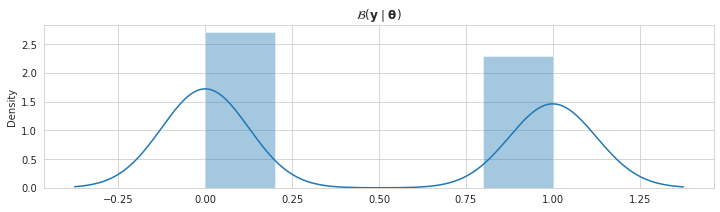

In [16]:
# <- your code
from torch.distributions import Bernoulli


p = Bernoulli(logits=torch.zeros((1000,)))
plt.figure(figsize=(12, 3))
sns.distplot(p.sample())
plt.title(r"$\mathcal{B}(\mathbf{y} \mid \mathbf{\theta})$")
plt.show()

## Dataset: MNIST

First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through the `classes` variable, to speed up training.

In [17]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
# classes = [3, 7]
classes=[0, 1, 4, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


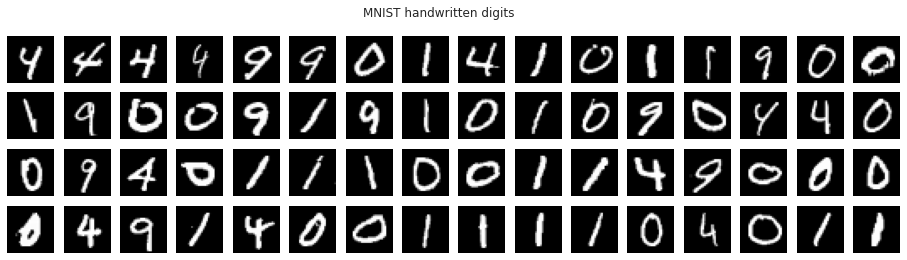

In [18]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

## Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [19]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256), ## adjusting to test
            nn.ReLU(),
            ## adding more layers to test performance ##
            nn.Linear(in_features=256, out_features=128), ## adjusting to test
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            ## add
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits, validate_args=False)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 2
vae = VariationalAutoencoder(images[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)


## Implement a module for Variational Inference

**Exercise 1**: implement `elbo` ($\mathcal{L}$) and `beta_elbo` ($\mathcal{L}^\beta$)

In [20]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta*kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [21]:
vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    544.424, shape: []
elbo   | mean =   -544.424, shape: [64]
log_px | mean =   -544.396, shape: [64]
kl     | mean =      0.028, shape: [64]


## Training and Evaluation

### Initialize the model, evaluator and optimizer

In [22]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 2
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

### Training Loop

**plotting guide**:

* 1st row: Reproducing the figure from the begining of the Notebook.
    * (Left) Data. 
    * (Middle) Latent space: the large gray disk reprensents the prior (radius = $2\sigma$), each point represents a latent sample $\mathbf{z}$. The smaller ellipses represent the distributions $q_\phi(\mathbf{z} | \mathbf{x})$  (radius = $2\sigma$). When using $\geq 2$ latent features, dimensionality reduction is applied using t-SNE and only samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ are displayed. 
    * (Right) samples from $p_\theta(\mathbf{x} | \mathbf{z})$.

* 2nd row: Training curves

* 2rd row: Latent samples. 
    * (Left) Prior samples $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim p(\mathbf{z})$ 
    * (Middle) Latent Interpolations. For each row: $\mathbf{x} \sim p_\theta(\mathbf{x} | t \cdot \mathbf{z}_1 + (1-t) \cdot \mathbf{z}_2), \mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z}), t=0 \dots 1$. 
    * (Right): Sampling $\mathbf{z}$ from a grid [-3:3, -3:3] $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim \operatorname{grid}(-3:3, -3:3)$ (only available for 2d latent space).

**NOTE** this will take a while on CPU.

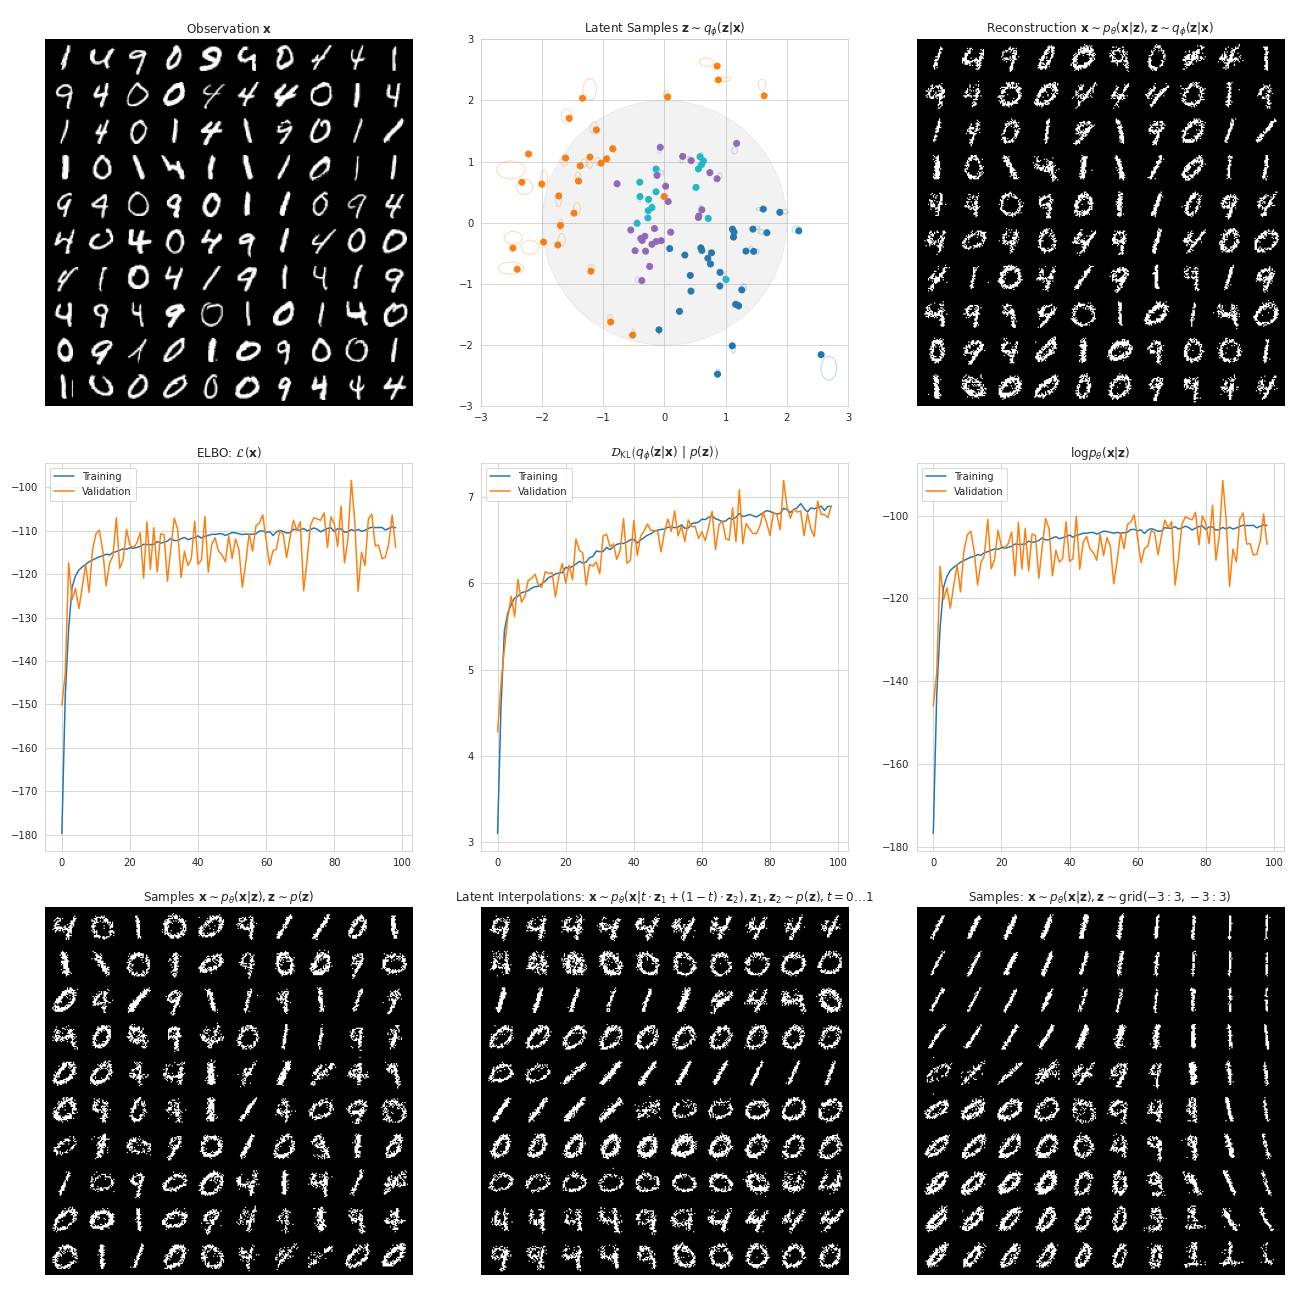

In [24]:
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

# Analyzing the VAE

## Mandatory Exercises

### Exercise 1.

1. Implement the class `ReparameterizedDiagonalGaussian` (`log_prob()` and `rsample()`).
2. Import the class `Bernoulli`
3. Implement the class `VariationalInference` (computation of the `elbo` and `beta_elbo`).

### Exercise 2.

**Trainnig and Evaluating a VAE model**

1. Why do we use the reparameterization trick?
2. What available metric can you use to estimate the marginal likelihood ($p_\theta(\mathbf{x})$) ?
3. In the above plots, we display numerous model samples. If you had to pick one plot, which one would you pick to evaluate the quality of a VAE (i.e. using posterior samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ or prior samples $\mathbf{z} \sim p(\mathbf{z})$) ? Why?.
4. How could you exploit the VAE model for classification?

**Answers**:

1. We use the reparameterization trick because it allows us to still keep the stochasticity of the model, while the mean and log-variance remain as the lernable parameters of the network [source](https://towardsdatascience.com/reparameterization-trick-126062cfd3c3).
2. To estimate the marginal likelihood, we can use the ELBO (Evidence Lower Bound) which is a lower bound to the marginal log-likelihood.
3. To evaluate the quality of a VAE I would use the ELBO plot since the goal would be to maximize the log-likelihood using ELBO.
4. We could train the image classifier on the compressed version of the samples $\mathbf{z}$ and save time/space by training it on lower dimension samples.

### Exercise 3.

**Experiment with the VAE model.**

1. Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
2. Try to increase the number of digit classes in the training set and analyze the learning curves, latent space and reconstructions. For which classes and why does the VAE fail in reconstructing?  *HINT: Try the combination: `classes=[0, 1, 4, 9]`, to see how well VAE can separate these digits in the latent representation and reconstructions.*
3. Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions?

**Answers**:

1. I tested changing the number of hidden units in the fully connected layers, and also adding more fully connected layers with RELU activation. I ended up finding the best performance by adding one more layer and increasing the hidden units.
2. The model has issues with recognizing the difference between 4 and 9.
3. Increasing the number of units in the latent layer improved its ability to classify elements in the latent space and has improved reconstructions.

### Exercise 4. 

**Analyze the purpose of the KL-term and the $\beta$ parameter.**

1. How does the KL-term, $\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$, work as a regulariser on the distributions over latent variables? *HINT*: When maximising the ELBO, the probability-distance measure is minimised $\operatorname{KL} \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $\operatorname{KL} = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal (i.e. $\mathbf{z}=\epsilon \sim \mathcal{N}(0,I)$) to the decoder.
2. Try removing the KL-term (using the $\beta$ parameter) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it.
3. What does the loss reduces to? Explain how this can affect a VAE. *HINT*: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p_\theta(\mathbf{x}|\mathbf{z}) = \log \mathcal{B}(\mathbf{x} | g_\theta(z))$, in VAEs.
4. Experiment with different $\beta$ values (e.g. [0.1, 10, 50]) and explain how this affects the reconstruction quality and the latent representations. *HINT* what is the tradeoff between reconstruction error ($\log p_\theta(\mathbf{x} | \mathbf{z})$) and the KL term?

**Answers**:

1. the KL-term makes the posterior and prior distributions match.
2. Setting $\beta$ to 0 caused the model to fail a few minutes into training. Thus it seems not possible to completely remove it....
3. The loss reduces to be the reconstruction error:
$$
\overbrace{
\mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[ \log p_\theta(\mathbf{x} | \mathbf{z})\right]
}^{\text{(a) Reconstruction Error}}
$$
4. Higher $\beta$ will encourage a disentangled representation and more efficient latent encoding. [source1](https://medium.com/analytics-vidhya/generative-modelling-using-variational-autoencoders-vae-and-beta-vaes-81a56ef0bc9f), [source2](https://lilianweng.github.io/posts/2018-08-12-vae/)

## Optional exercises

- OPT: Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.
- OPT: Look through https://arxiv.org/abs/1611.00712 or https://arxiv.org/abs/1611.01144 and explain how one could instead introduce a categorical latent variable for $z$.
- OPT: Implement the Gumbel softmax trick thereby letting $z$ take a categorical distribution.
- OPT: The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf or again the two papers on Gumbel softmax.

**Answers**:

`[...]`

# Credits 

- Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
- Converted to TensorFlow and updated by Maximillian F. Vording ([maximillian91](https://github.com/maximillian91)).
- Converted to PyTorch and updated by Jesper Wohlert ([wohlert](https://github.com/wohlert)).
- Major update in 2020: focus on the probabilistic interpretation, use of `torch.distributions` and improved visualizations by Valentin Lievin ([vlievin](http://vlievin.github.io)).

# Supplementary Material

## Why a VAE learns a good approximate posterior $q_\phi(\mathbf{z} | \mathbf{x}) \approx p_\theta(\mathbf{z} | \mathbf{x})$

In order to compare the two distributions, let us focus on their KL-divergence (**important**: the divergence is expressed w.r.t $p_\theta(\mathbf{z}|\mathbf{x})$ and not $p(\mathbf{z})$, this is not the KL-divergence studied in the experiments):

$$\mathcal{D}_{\operatorname{KL}}(q_\phi(\mathbf{z} | \mathbf{x}) || p_\theta(\mathbf{z} | \mathbf{x})) = \int_z q_\phi(\mathbf{z} | \mathbf{x}) \log \frac{q_\phi(\mathbf{z} | \mathbf{x}) }{p_\theta(\mathbf{z} | \mathbf{x})}dz = \mathbb{E}_{q_\phi(\mathbf{z} | \mathbf{x})} \left[\log \frac{q_\phi(\mathbf{z} | \mathbf{x}) }{p_\theta(\mathbf{z} | \mathbf{x})}\right]$$

which is a non-negative distance measure between distributions, so by minimising it wrt. to the parameters in $q_\phi(\mathbf{z} | \mathbf{x}) $, the distribution moves close to our unknown $p_\theta(\mathbf{z} | \mathbf{x})$. But as $p_\theta(\mathbf{z} | \mathbf{x})$ is unknown and would include some rather intractable integrals over neural networks, we can instead get rid of it by expressing it through Bayes rule $p(z|x) = p(x|z)p(z)/p(x)$ and thereby decompose the KL-divergence into our log-likelihood and lower bound:

$$ \mathcal{D}_{\operatorname{KL}}(q_\phi(\mathbf{z} | \mathbf{x})  || p_\theta(\mathbf{z} | \mathbf{x})) 
= \int_\mathbf{z} q_\phi(\mathbf{z} | \mathbf{x}) \log \frac{q_\phi(\mathbf{z} | \mathbf{x}) p_\theta(\mathbf{x})}{p_\theta(\mathbf{x} | \mathbf{z})
p(z)}d\mathbf{z}
= \int_\mathbf{z} q_\phi(\mathbf{z} | \mathbf{x}) \log \frac{q_\phi(\mathbf{z} | \mathbf{x}) }{p_\theta(\mathbf{x} | \mathbf{z})p_\theta(\mathbf{x} | \mathbf{z})(\mathbf{z})}d\mathbf{z} + \log p_\theta(\mathbf{x})$$ 

by seeing that the likelihood, $p_\theta(\mathbf{x})$, is independent of $\mathbf{z}$ and pull it out of the integral. We can flip the sign and fraction in the integral term to recognise it as the negative lower bound

$$\mathcal{D}_{\operatorname{KL}}(q_\phi(\mathbf{z} | \mathbf{x})  || p_\theta(\mathbf{z} | \mathbf{x})) = - \int_z q_\phi(\mathbf{z} | \mathbf{x}) \log \frac{p_\theta(\mathbf{x} | \mathbf{z})p(\mathbf{z})}{q_\phi(\mathbf{z} | \mathbf{x}) }dz + \log p_\theta(\mathbf{x}) =  -\mathcal{L}(x) + \log p_\theta(\mathbf{x})$$

We then find the log-likelihood to consist of the two terms and hold the inequality

$$\log p_\theta(\mathbf{x}) =  \mathcal{D}_{\operatorname{KL}}(q_\phi(\mathbf{z} | \mathbf{x})  || p_\theta(\mathbf{z} | \mathbf{x})) + \mathcal{L}(\mathbf{x}) \geq \mathcal{L}(\mathbf{x})$$

where the KL-divergence is non-zero and the log-likelihood is $\log p_\theta(\mathbf{x}) \leq 0$. This means that maximising the lower bound from the negative domain towards $0$ will also maximise the log-likelihood, while pushing down the KL-divergence until $q_\phi(\mathbf{z} | \mathbf{x}) $ cannot move closer to natures true distribution, $p_\theta(\mathbf{z} | \mathbf{x})$. So how close the lower bound can get to the log-likelihood is dependent on the flexibility of the distribution we choose for $q_\phi(\mathbf{z} | \mathbf{x}) $. 



## Importance Sampling in VAEs

In VAEs, the true posterior distribution $p_\theta(\mathbf{z} | \mathbf{x})$ is unknown. Instead we use an approximate posterior $q_\theta(\mathbf{z} | \mathbf{x})$. $q$ is tractable and one can sample from it. This is an instance of importance-sampling: evaluating a quantity $\mathbb{E}_{p(\mathbf{z})} \left[  f(\mathbf{z})\right]$ given samples from another distribtion $q$.

### 1. Illustration

Let us consider a small example to illustrate importance-sampling. In this example we define a distribution $p(\mathbf{z})$ from which we (in practice) cannot sample and define a distribution $q(\mathbf{z})$ from which we can sample. 

Then we can estimate $\mathbb{E}_{p(\mathbf{z})} \left[  f(\mathbf{z})\right]$ using samples from $q$:

$$\mathbb{E}_{p(\mathbf{z})} \left[  f(\mathbf{z})\right] = \mathbb{E}_{q(\mathbf{z})} \left[ w(\mathbf{z}) f(\mathbf{z})\right], \quad w(\mathbf{z}) := \frac{p(\mathbf{z})}{q(\mathbf{z})}$$

In this example, we use $f(\mathbf{z}) = \mathbf{z}$.

In [ ]:
import torch
from torch import nn
from torch.distributions import Normal
cuda = torch.cuda.is_available()
    
n_samples = 10000
c1 = sns.color_palette()[0]
c2 = sns.color_palette()[1]

# define p(z) and q(z)
p = Normal(loc=5 * torch.ones((1,)), scale=torch.ones((1,))) 
q = Normal(loc=torch.ones((1,)), scale=3*torch.ones((1,)))

# sample z ~ q(z)
q_samples = q.sample(sample_shape=torch.Size([n_samples]))

# compute the densities p(z) and q(z)
p_prob = p.log_prob(q_samples).exp()
q_prob = q.log_prob(q_samples).exp()

# define the importance-weights: w(z) = p(z) / q(z)
w = p_prob / (q_prob + 1e-12)

# compute the importance-weighted estimate \hat{\mu} = E_q[ w(z) f(z)] where f(z) = z
estimate = (w * q_samples).mean()

# compute the ground true
p_samples = p.sample(sample_shape=torch.Size([n_samples]))
empirical_mean = p_samples.mean()

# display the results
print(f">> Empirical mean = {empirical_mean:.3f}, estimate = {estimate:.3f}")
plt.figure(figsize=(16,6))
sns.distplot(p_samples, label="$p(z)$", hist_kws={'alpha':0.2}, color=c1)
sns.distplot(q_samples, label="$q(z)$",hist_kws={'alpha':0.2}, color=c2)
plt.axvline(empirical_mean, color=c1,linestyle="-",label= "Empirical Mean")
plt.axvline(estimate, color=c2,linestyle="-", label= "Importance-Weighted Estimate")
plt.legend()
plt.show()

### 2. Application: Accurate Estimate of $\log p_\theta(\mathbf{x})$ using Importance Sampling

The ELBO is a lower bound to the marginal log likelihood, however it is not guaranteed to be accurate. [Importance-sampling can be leveraged in VAEs](https://arxiv.org/abs/1509.00519) to provide a more accurate estimate of the marginal log-likelihood $\log p_\theta(\mathbf{x})$ using multiple samples from $q_\phi(\mathbf{z}_1,\dots,\mathbf{z}_K | \mathbf{x})$. With $K+1$ samples $q_\phi(\mathbf{z} | \mathbf{x})$, the following inequality holds:

$$\log p_\theta(\mathbf{x}) \geq \mathcal{L}_{K+1}(\mathcal{x}) \geq \mathcal{L}_K(\mathcal{x}) \geq \mathcal{L}(\mathcal{x})$$

where

$$ \mathcal{L}_{K}(\mathcal{x}) := \mathbb{E}_{q_\phi(\mathbf{z}_1,\dots,\mathbf{z}_K | \mathbf{x})} \left[ 
\log \frac{1}{K} \sum_{k=1}^K \frac{p_\theta(\mathbf{x}, \mathbf{z}_k)}{q_\phi(\mathbf{z}_k | \mathbf{x})} 
\right]$$

